# Fine-tuning on Pre-trained Model for Multiomic Integration
In this tutorial, we demonstrate how to fine-tune a pre-trained model for multiomic integration. We use the BMMC dataset as an example for RNA and protein abundance data integration from CITE-seq. The BMMC dataset consists of multiple batches by donor origin. In the paired integration setting, each cell contains both RNA and protein measurements. We fine-tune on the pre-trained whole-body model.

We summarize the fine-tuning pipeline in the following steps, which can be used as a general recipe for finetuning on integration tasks and beyond: 

     1. Specify hyper-parameter setup for integration task
     
     2. Load and pre-process data
     
     3. Load the pre-trained scGPT model
     
     4. Finetune scGPT with task-specific objectives
     
     5. Evaluate fine-tuned scGPT

In [32]:
import copy
import gc
import json
import os
from pathlib import Path
import sys
import time
import traceback
#from typing import List, Tuple, Dict, Union, Optional
import warnings

%load_ext autoreload
%autoreload 2

import torch
from anndata import AnnData
import scanpy as sc
import scvi
import numpy as np
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
import pandas as pd
import scipy.sparse as sp
from sklearn import preprocessing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
sys.path.insert(0, "../")
from scgpt import prepare_data, prepare_dataloader, define_wandb_metrcis, evaluate, eval_testdata, train
from scgpt.tokenizer import tokenize_and_pad_batch
from scgpt.model import MultiOmicTransformerModel

import scgpt as scg
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.tokenizer import random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [34]:
import torch
import torchtext
print(torch.__version__)
print(torchtext.__version__)

2.2.2+cu118
0.18.0+cpu


In [35]:
import torch
print(torch.__version__)


2.2.2+cu118


In [36]:
import torch
print(torch.__version__)


2.2.2+cu118


## Step1: Specify hyper-parameter setup for integration task
Here we provide some hyper-parameter recommendations for the multiomic integration task. Note that the BMMC dataset contains multiple batches to be integrated. Therefore, in addition to the default gene modelling objectives, we also turn on DAR objectives specifically to faciliate batch integration. We also turn on the use_mod argument as default to ensure that the model is modality-aware during training.

In [37]:
#tuned
hyperparameter_defaults = dict(
    task = 'multiomic',
    seed=42,
    dataset_name="BMMC", # Dataset name
    do_train=True, # Flag to indicate whether to do update model parameters during training
    load_model="../save/scGPT_human", # Path to pre-trained model
    freeze = False, #freeze
    GEP=True, # Gene expression modelling
    GEPC=True, # Gene expression modelling for cell objective
    CLS=False,
    ESC=False,
    DAR = True, # DAR objective weight for batch correction
    DSBN = False,  # Domain-spec batchnorm,
    mask_ratio=0.4, # Default mask ratio
    explicit_zero_prob = False,  # whether explicit bernoulli for zeros
    ecs_thres=0,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=1.0,
    use_batch_labels = True,
    use_mod = True,
    per_seq_batch_sample = False,
    epochs=20, # Default number of epochs for fine-tuning
    input_layer_key = "X_binned", # Default expression value binning in data pre-processing
    n_bins=51, # Default number of bins for value binning in data pre-processing
    n_hvg = 1200,  # Default number of highly variable genes
    n_hvp = 4000,
    max_seq_len = 4001, # # Default n_hvg+1
    lr=0.0004614941433845602, # Default learning rate for fine-tuning
    batch_size=32, # Default batch size for fine-tuning
    layer_size=512,
    nlayers=5,
    nhead=8, # if load model, batch_size, layer_size, nlayers, nhead will be ignored
    dropout=0.2, # Default dropout rate during model fine-tuning
    schedule_ratio=0.95,  # Default rate for learning rate decay
    save_eval_interval=5, # Default model evaluation interval
    log_interval=100, # Default log interval
    fast_transformer=False, # Default setting
    pre_norm=False, # Default setting
    amp=True,  # Default setting: Automatic Mixed Precision
    pad_token = "<pad>",
    mask_value = -1,
    pad_value = -2,
    include_zero_gene = False,
    )

In [38]:
# #benchmark
# hyperparameter_defaults = dict(
#     task = 'multiomic',
#     seed=42,
#     dataset_name="BMMC", # Dataset name
#     do_train=True, # Flag to indicate whether to do update model parameters during training
#     load_model="../save/scGPT_human", # Path to pre-trained model
#     freeze = False, #freeze
#     GEP=True, # Gene expression modelling
#     GEPC=True, # Gene expression modelling for cell objective
#     CLS=False,
#     ESC=False,
#     DAR = True, # DAR objective weight for batch correction
#     DSBN = False,  # Domain-spec batchnorm,
#     mask_ratio=0.4, # Default mask ratio
#     explicit_zero_prob = False,  # whether explicit bernoulli for zeros
#     ecs_thres=0,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
#     dab_weight=1.0,
#     use_batch_labels = True,
#     use_mod = True,
#     per_seq_batch_sample = False,
#     epochs=25, # Default number of epochs for fine-tuning
#     input_layer_key = "X_binned", # Default expression value binning in data pre-processing
#     n_bins=51, # Default number of bins for value binning in data pre-processing
#     n_hvg = 1200,  # Default number of highly variable genes
#     n_hvp = 4000,
#     max_seq_len = 4001, # # Default n_hvg+1
#     lr=1e-3, # Default learning rate for fine-tuning
#     batch_size=16, # Default batch size for fine-tuning
#     layer_size=512,
#     nlayers=4,
#     nhead=8, # if load model, batch_size, layer_size, nlayers, nhead will be ignored
#     dropout=0.2, # Default dropout rate during model fine-tuning
#     schedule_ratio=0.95,  # Default rate for learning rate decay
#     save_eval_interval=5, # Default model evaluation interval
#     log_interval=100, # Default log interval
#     fast_transformer=False, # Default setting
#     pre_norm=False, # Default setting
#     amp=True,  # Default setting: Automatic Mixed Precision
#     pad_token = "<pad>",
#     mask_value = -1,
#     pad_value = -2,
#     include_zero_gene = False,
# )

In [39]:
run = wandb.init(
    config=hyperparameter_defaults,
    project="scGPT",
    reinit=True,
    settings=wandb.Settings(start_method="thread"),
)
config = wandb.config
print(config)

set_seed(config.seed)

{'task': 'multiomic', 'seed': 42, 'dataset_name': 'BMMC', 'do_train': True, 'load_model': '../save/scGPT_human', 'freeze': False, 'GEP': True, 'GEPC': True, 'CLS': False, 'ESC': False, 'DAR': True, 'DSBN': False, 'mask_ratio': 0.4, 'explicit_zero_prob': False, 'ecs_thres': 0, 'dab_weight': 1.0, 'use_batch_labels': True, 'use_mod': True, 'per_seq_batch_sample': False, 'epochs': 20, 'input_layer_key': 'X_binned', 'n_bins': 51, 'n_hvg': 1200, 'n_hvp': 4000, 'max_seq_len': 4001, 'lr': 0.0004614941433845602, 'batch_size': 32, 'layer_size': 512, 'nlayers': 5, 'nhead': 8, 'dropout': 0.2, 'schedule_ratio': 0.95, 'save_eval_interval': 5, 'log_interval': 100, 'fast_transformer': False, 'pre_norm': False, 'amp': True, 'pad_token': '<pad>', 'mask_value': -1, 'pad_value': -2, 'include_zero_gene': False}


In [40]:
# settings for input and preprocessing
special_tokens = [config.pad_token, "<cls>", "<eoc>"]

In [41]:
dataset_name = config.dataset_name
save_dir = Path(f"./save/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")

save to save\dev_BMMC-Jan04-09-24


## Step 2: Load and pre-process data

### 2.1 Load the BMMC data
Please download the data from https://drive.google.com/file/d/10RxboePS5p2Jj2Sfq1Ghzgqnl6nqPv5V/view?usp=sharing

For the purpose of this tutorial, we selected a 12K+ cell subset from the BMMC dataset (originally 90K+ cells) to speed up training. More specifically, we filtered on the first 3 donors (batches) with B, Mono and T cell subtypes as shown in the data loading step below.

In [42]:
if dataset_name == 'BMMC':
    adata = sc.read('BMMC_processed.h5ad')
    # subset to first 3 donors with B, Mono and T cell subtypes
    adata = adata[adata.obs.DonorID.isin([10886, 11466, 12710]) & adata.obs.cell_type.isin(np.unique(adata.obs.cell_type.values)[:17])]
    adata.obs["celltype"] = adata.obs["cell_type"].astype(str).astype('category')
    adata.var["gene_name"] = adata.var.index.tolist()
    le = preprocessing.LabelEncoder()
    encoded_batch = le.fit_transform(adata.obs['batch'].values)
    adata.obs["batch_id"] =  encoded_batch
    adata.obs["str_batch"] = adata.obs["batch_id"].astype('category')
    adata_protein = adata[:, adata.var.feature_types.isin(['ADT'])].copy()
    adata_protein.var.index = ['p_' + i for i in adata_protein.var.index]
    adata = adata[:, adata.var.feature_types.isin(['GEX'])].copy()
    data_is_raw = False

In [43]:
if config.use_mod:
    gene_rna_df = pd.DataFrame(index = adata.var.index.tolist())
    gene_rna_df['mod'] = 'RNA'
    gene_protein_df = pd.DataFrame(index = adata_protein.var.index.tolist())
    gene_protein_df['mod'] = 'Protein'
    gene_loc_df = pd.concat([gene_rna_df, gene_protein_df])
    gene_loc_df['mod'] = gene_loc_df['mod'].astype('category')

### 2.2 Cross-check gene set with the pre-trained model 
Note that we retain the common gene set between the data and the pre-trained model for further fine-tuning.

In [44]:
if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    old_vocab = vocab
embsize = config.layer_size
nhead = config.nhead
nlayers = config.nlayers
d_hid = config.layer_size

scGPT - INFO - match 12587/13953 genes in vocabulary of size 60697.


### 2.3 Pre-process the data
We follow the standardized pipline of depth normalization, log normalization, and highly vairable gene (HVG) selection for data pre-processing. We further introduce value binning to obtain the relative expressions of each HVG. Given multiple sequencing modalities, we perform the pre-processing steps on each individual modality first, and then combine them into multi-modal sequences as model input.

#### 2.3.1 Pre-process the RNA data

In [45]:
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=1,  # step 1
    filter_cell_by_counts=1,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=config.n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key=None)

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Filtering cells by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Binning data ...


#### 2.3.2 Pre-process the Protein data

In [46]:
preprocessor_protein = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=0,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=False,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=False,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor=None,
    binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor_protein(adata_protein, batch_key=None)

scGPT - INFO - Binning data ...


#### 2.3.3 Combine RNA, and Protein data

In [47]:
data_combined = np.concatenate([adata.layers["X_binned"], adata_protein.layers["X_binned"]], axis=1)
adata = AnnData(
    X=data_combined,
    obs=adata.obs,
    var=pd.DataFrame(index=adata.var_names.tolist() + adata_protein.var_names.tolist()),
    layers={"X_binned": data_combined,}
)
adata.var["gene_name"] = adata.var.index.tolist()

In [48]:
adata

AnnData object with n_obs × n_vars = 12578 × 1334
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'celltype', 'batch_id', 'str_batch', 'n_counts'
    var: 'gene_name'
    layers: 'X_binned'

In [49]:
if config.per_seq_batch_sample:
    # sort the adata by batch_id in advance
    adata_sorted = adata[adata.obs["batch_id"].argsort()].copy()

### 2.4 Tokenize the input data for model fine-tuning

In [50]:
all_counts = (
    adata.layers[config.input_layer_key].A
    if issparse(adata.layers[config.input_layer_key])
    else adata.layers[config.input_layer_key]
)
genes = adata.var["gene_name"].tolist()

celltypes_labels = adata.obs["celltype"].tolist()  # make sure count from 0
num_types = len(set(celltypes_labels))
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

In [51]:
if config.use_mod:
    mod_type = np.array([gene_loc_df.loc[g, 'mod'] for g in genes])
    vocab_mod = Vocab(VocabPybind(np.unique(gene_loc_df['mod']).tolist() + special_tokens, None))
    vocab_mod.set_default_index(vocab_mod["<pad>"])
    mod_type = np.array(vocab_mod(list(mod_type)), dtype=int)
    ntokens_mod = len(vocab_mod)

In [52]:
(
    train_data,
    valid_data,
    train_celltype_labels,
    valid_celltype_labels,
    train_batch_labels,
    valid_batch_labels,
) = train_test_split(
    all_counts, celltypes_labels, batch_ids, test_size=0.1, shuffle=True
)


In [53]:
num_of_non_zero_genes = [
    np.count_nonzero(train_data[i]) for i in range(train_data.shape[0])
]
print(f"max num of non_zero genes: {np.max(num_of_non_zero_genes)}")
print(f"min num of non_zero genes: {np.min(num_of_non_zero_genes)}")
print(f"average num of non_zero genes: {np.mean(num_of_non_zero_genes)}")
print(
    f"99% quantile num of non_zero genes: {np.quantile(num_of_non_zero_genes, 0.99)}"
)
print(f"max original values: {np.max(train_data)}")
print(
    f"average original non_zero values: {np.mean(train_data[np.nonzero(train_data)])}"
)
print(
    f"99% quantile original non_zero values: {np.quantile(train_data[np.nonzero(train_data)], 0.99)}"
)
print(f"num of celltypes: {num_types}")

max num of non_zero genes: 687
min num of non_zero genes: 206
average num of non_zero genes: 341.5295053003534
99% quantile num of non_zero genes: 510.0
max original values: 50
average original non_zero values: 25.3482856428962
99% quantile original non_zero values: 49.0
num of celltypes: 17


In [54]:
if config.load_model is None:
    vocab = Vocab(VocabPybind(genes + special_tokens, None))
    vocab.set_default_index(vocab["<pad>"])
    gene_ids = np.array(vocab(genes), dtype=int)
else:
    pretrained_genes = [g for g in genes + special_tokens if g in old_vocab]
    new_genes = [g for g in genes + special_tokens if g not in old_vocab]
    gene_ids_pretrained = np.array(old_vocab(pretrained_genes), dtype=int)
    # https://discuss.pytorch.org/t/expand-an-existing-embedding-and-linear-layer-nan-loss-value/55670/2
    # Retrieve pretrained weights
    vocab = Vocab(VocabPybind(pretrained_genes + new_genes, None))
    vocab.set_default_index(vocab["<pad>"])
    gene_ids = np.array(vocab(genes), dtype=int)

In [55]:
tokenized_train = tokenize_and_pad_batch(
    train_data,
    gene_ids,
    max_len=config.max_seq_len,
    vocab=vocab,
    pad_token=config.pad_token,
    pad_value=config.pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=config.include_zero_gene,
    mod_type=mod_type if config.use_mod else None,
    vocab_mod=vocab_mod if config.use_mod else None,
)
tokenized_valid = tokenize_and_pad_batch(
    valid_data,
    gene_ids,
    max_len=config.max_seq_len,
    vocab=vocab,
    pad_token=config.pad_token,
    pad_value=config.pad_value,
    append_cls=True,
    include_zero_gene=config.include_zero_gene,
    mod_type=mod_type if config.use_mod else None,
    vocab_mod=vocab_mod if config.use_mod else None,
)
logger.info(
    f"train set number of samples: {tokenized_train['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['genes'].shape[1]}"
)
logger.info(
    f"valid set number of samples: {tokenized_valid['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_valid['genes'].shape[1]}"
)

scGPT - INFO - train set number of samples: 11320, 
	 feature length: 688
scGPT - INFO - valid set number of samples: 1258, 
	 feature length: 663


## Step 3: Load the pre-trained scGPT model
Note that for multiomic integration, since the pre-trained model does not include the ATAC and protein tokens, we expand the embedding layer by adding these new tokens. We inherit only the gene embedding layer from the pre-trained model, and train rest of the model from scratch.

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dict = torch.load(model_file)
ntokens = len(vocab)  # size of vocabulary
model = MultiOmicTransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid, 
    nlayers,
    vocab=vocab,
    dropout=config.dropout,
    pad_token=config.pad_token,
    pad_value=config.pad_value,
    do_mvc=config.GEPC,
    do_dab=config.DAR,
    use_batch_labels=config.use_batch_labels,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=config.DSBN,
    n_input_bins=config.n_bins,
    ecs_threshold=config.ecs_thres,
    explicit_zero_prob=config.explicit_zero_prob,
    use_fast_transformer=config.fast_transformer,
    pre_norm=config.pre_norm,
    use_mod=config.use_mod,
    ntokens_mod=ntokens_mod if config.use_mod else None,
    vocab_mod=vocab_mod if config.use_mod else None,
)

with torch.no_grad():
    pretrained_emb_weights = model_dict['encoder.embedding.weight'][gene_ids_pretrained, :]
    model.encoder.embedding.weight.data[:len(pretrained_genes), :] = pretrained_emb_weights
    model.encoder.enc_norm.weight.data = model_dict['encoder.enc_norm.weight']
ntokens = len(vocab)

model.to(device)
wandb.watch(model)
print(model)

MultiOmicTransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(1337, 512, padding_idx=1089)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (batch_encoder): BatchLabelEncoder(
    (embedding): Embedding(3, 512)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (mod_encoder): BatchLabelEncoder(
    (embedding): Embedding(5, 512, padding_idx=2)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-4): 5 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQua

In [57]:
if config.GEP and config.GEPC:
    criterion_gep_gepc = masked_mse_loss
if config.CLS:
    criterion_cls = nn.CrossEntropyLoss()
if config.DAR:
    criterion_dab = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=config.lr, eps=1e-4 if config.amp else 1e-8
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=config.schedule_ratio)
scaler = torch.cuda.amp.GradScaler(enabled=config.amp)

## Step 4: Finetune scGPT with task-specific objectives

random masking at epoch   1, ratio of masked values in train:  0.3988
scGPT - INFO - | epoch   1 | 100/354 batches | lr 0.00046 | ms/batch 189.18 | loss 3150.73 | gep 402.68 |gepc 2746.95 |dar  1.11 |
scGPT - INFO - | epoch   1 | 200/354 batches | lr 0.00046 | ms/batch 181.56 | loss 326.79 | gep 201.70 |gepc 124.11 |dar  0.97 |
scGPT - INFO - | epoch   1 | 300/354 batches | lr 0.00046 | ms/batch 182.20 | loss 256.01 | gep 170.29 |gepc 84.73 |dar  1.00 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   1 | time: 82.98s | valid loss 78.5472 | 
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 78.5472
random masking at epoch   2, ratio of masked values in train:  0.3988
scGPT - INFO - | epoch   2 | 100/354 batches | lr 0.00044 | ms/batch 184.61 | loss 133.48 | gep 67.94 |gepc 64.77 |dar  0.77 |
scGPT - INFO - | 

100%|██████████| 394/394 [00:19<00:00, 20.73it/s]


Recompute neighbors on rep X_scGPT instead of None
Cluster for cluster_0.2 with leiden
Cluster for cluster_0.4 with leiden
Cluster for cluster_0.6 with leiden
Cluster for cluster_0.8 with leiden
Cluster for cluster_1.0 with leiden
Cluster for cluster_1.2 with leiden
Cluster for cluster_1.4 with leiden
Cluster for cluster_1.6 with leiden
Cluster for cluster_1.8 with leiden
Cluster for cluster_2.0 with leiden
NMI...
ARI...
Silhouette score...
PC regression...
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.593915
ARI_cluster/label          0.355175
ASW_label                  0.664249
ASW_label/batch            0.812283
PCR_batch                  0.349859
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.866259
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     N

100%|██████████| 394/394 [00:18<00:00, 20.74it/s]


Recompute neighbors on rep X_scGPT instead of None
Cluster for cluster_0.2 with leiden
Cluster for cluster_0.4 with leiden
Cluster for cluster_0.6 with leiden
Cluster for cluster_0.8 with leiden
Cluster for cluster_1.0 with leiden
Cluster for cluster_1.2 with leiden
Cluster for cluster_1.4 with leiden
Cluster for cluster_1.6 with leiden
Cluster for cluster_1.8 with leiden
Cluster for cluster_2.0 with leiden
NMI...
ARI...
Silhouette score...
PC regression...
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.701257
ARI_cluster/label          0.625439
ASW_label                  0.661685
ASW_label/batch            0.851269
PCR_batch                  0.459349
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.913474
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     N

100%|██████████| 394/394 [00:18<00:00, 20.74it/s]


Recompute neighbors on rep X_scGPT instead of None
Cluster for cluster_0.2 with leiden
Cluster for cluster_0.4 with leiden
Cluster for cluster_0.6 with leiden
Cluster for cluster_0.8 with leiden
Cluster for cluster_1.0 with leiden
Cluster for cluster_1.2 with leiden
Cluster for cluster_1.4 with leiden
Cluster for cluster_1.6 with leiden
Cluster for cluster_1.8 with leiden
Cluster for cluster_2.0 with leiden
NMI...
ARI...
Silhouette score...
PC regression...
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.660762
ARI_cluster/label          0.486691
ASW_label                  0.652083
ASW_label/batch            0.866439
PCR_batch                  0.498838
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.931725
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     N

100%|██████████| 394/394 [00:19<00:00, 20.71it/s]


Recompute neighbors on rep X_scGPT instead of None
Cluster for cluster_0.2 with leiden
Cluster for cluster_0.4 with leiden
Cluster for cluster_0.6 with leiden
Cluster for cluster_0.8 with leiden
Cluster for cluster_1.0 with leiden
Cluster for cluster_1.2 with leiden
Cluster for cluster_1.4 with leiden
Cluster for cluster_1.6 with leiden
Cluster for cluster_1.8 with leiden
Cluster for cluster_2.0 with leiden
NMI...
ARI...
Silhouette score...
PC regression...
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.702443
ARI_cluster/label          0.661480
ASW_label                  0.647168
ASW_label/batch            0.878938
PCR_batch                  0.520354
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.928993
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     N

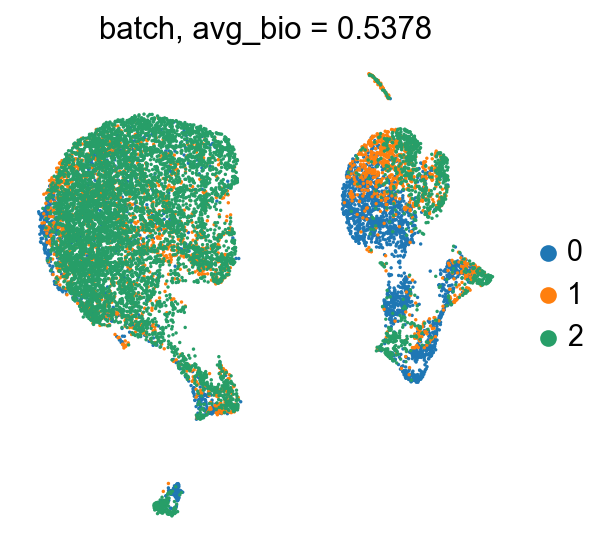

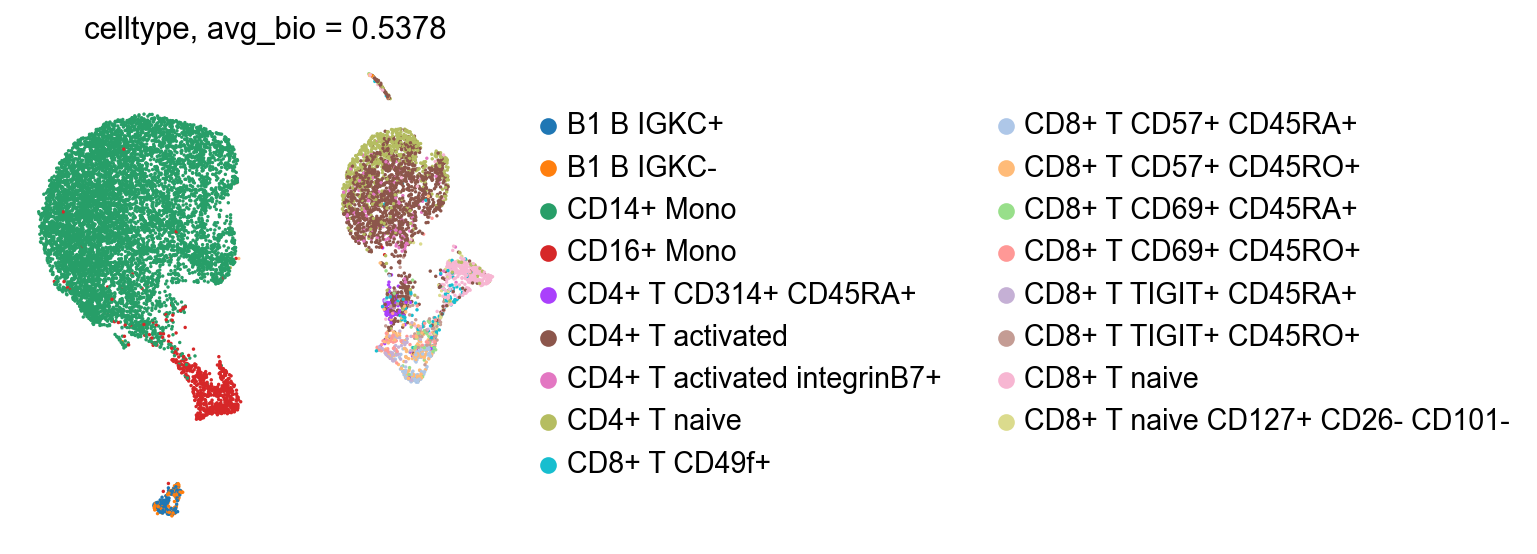

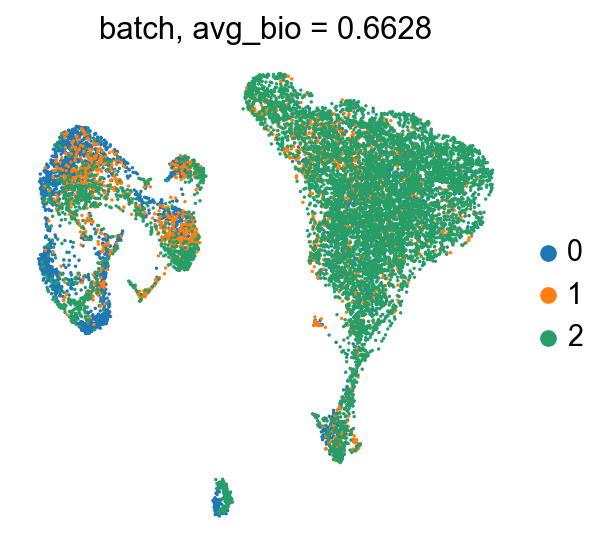

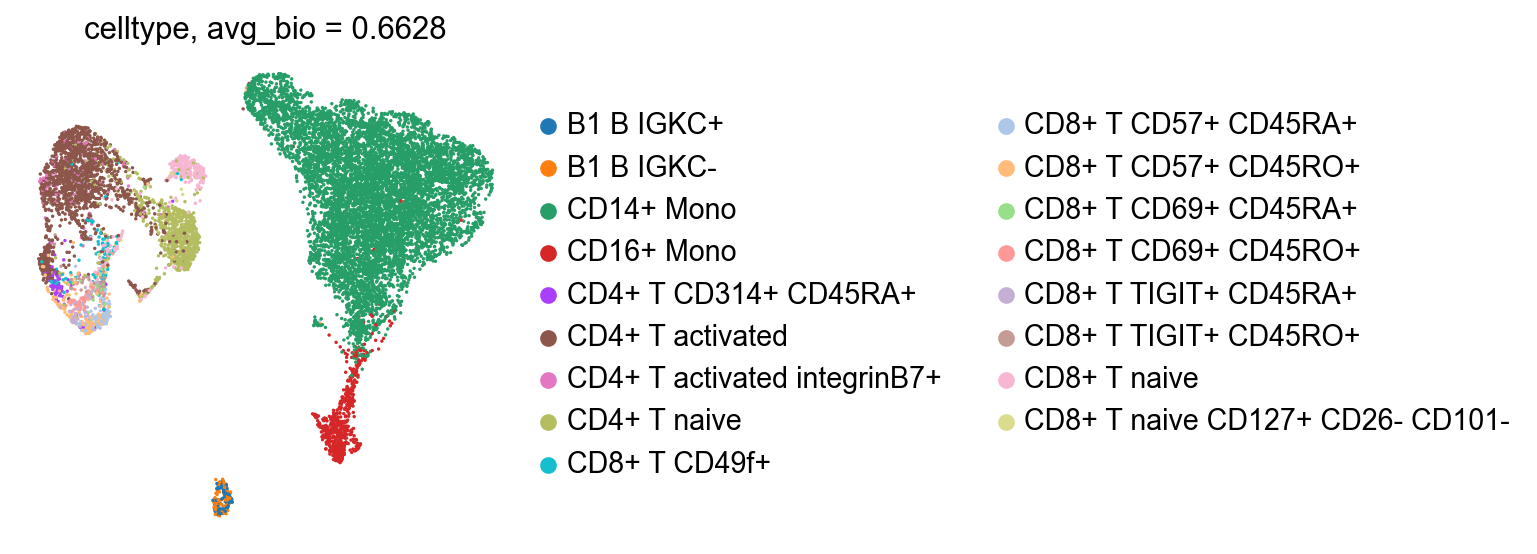

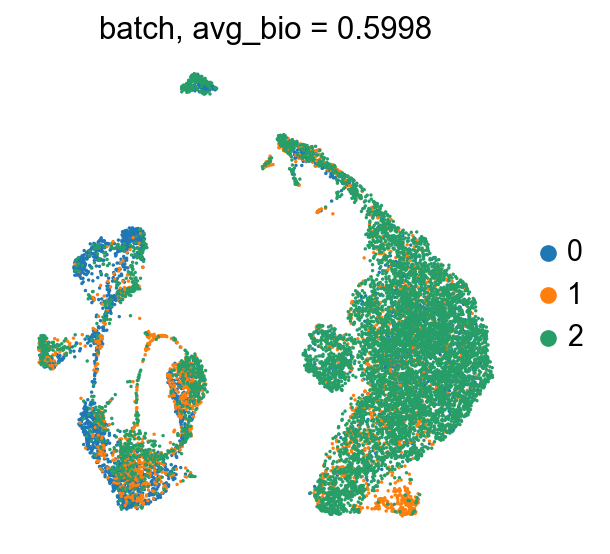

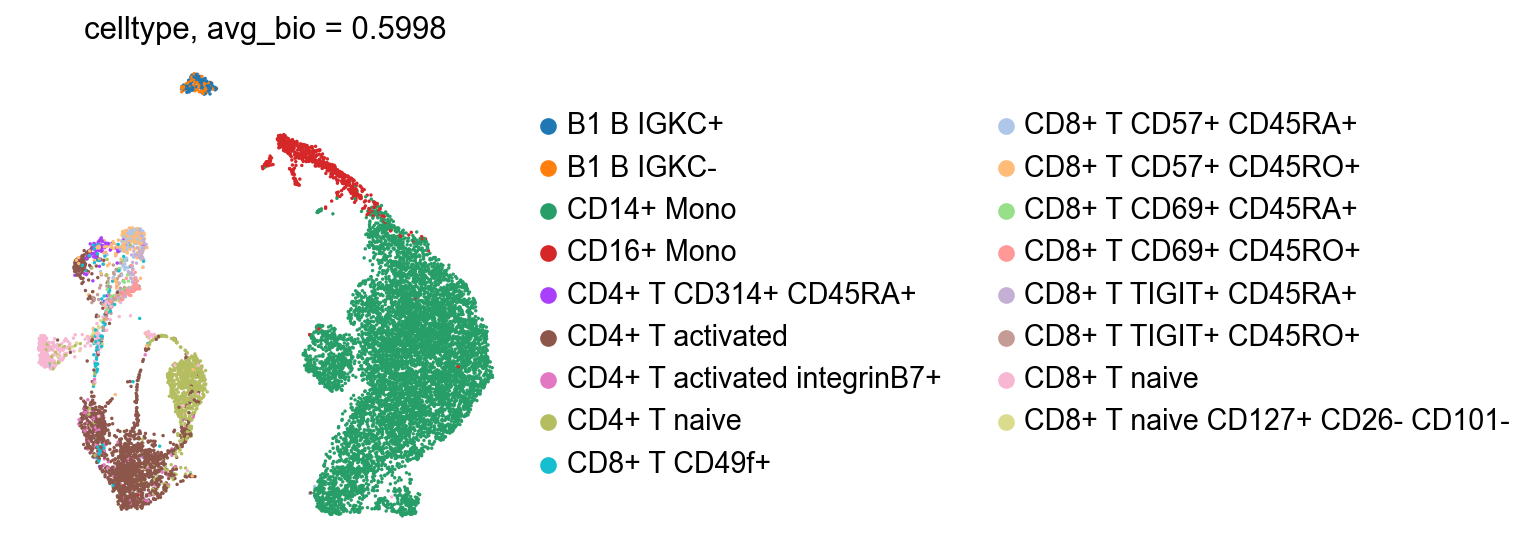

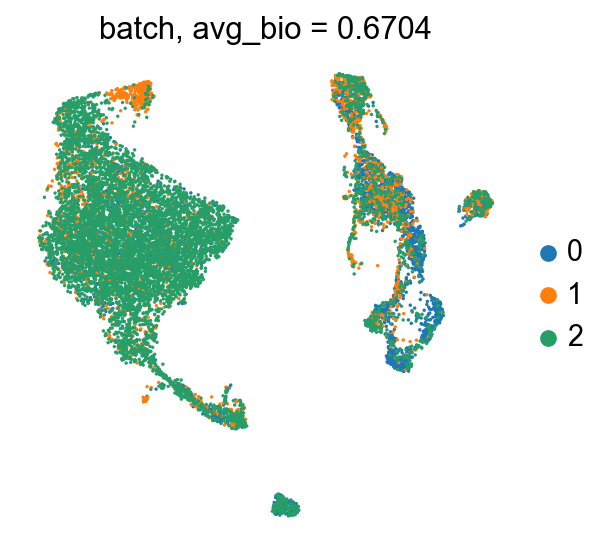

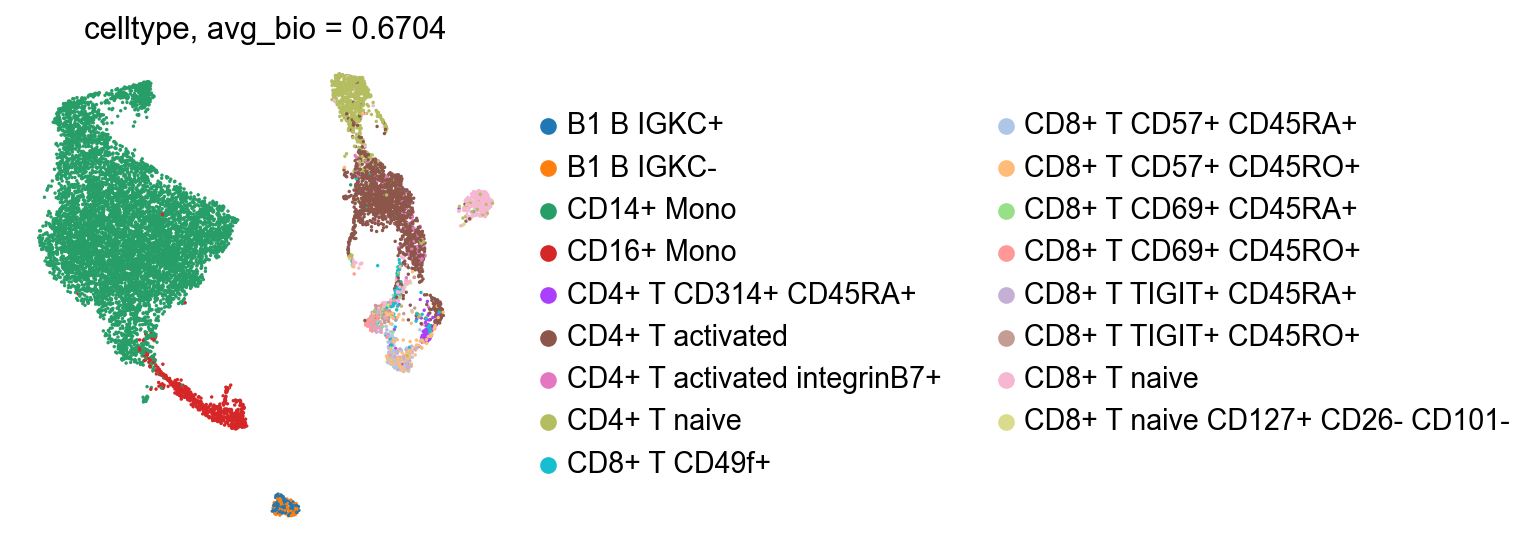

In [58]:
best_val_loss = float("inf")
best_avg_bio = 0.0
best_model = None
define_wandb_metrcis()

train_losses = []
val_losses = []

for epoch in range(1, config.epochs +1):
    epoch_start_time = time.time()
    train_data_pt, valid_data_pt = prepare_data(
        tokenized_train=tokenized_train, 
        tokenized_valid=tokenized_valid, 
        train_batch_labels=train_batch_labels,
        valid_batch_labels=valid_batch_labels,
        config=config,
        epoch=epoch,
        sort_seq_batch=config.per_seq_batch_sample)
    
    train_loader = prepare_dataloader(
        train_data_pt,
        batch_size=config.batch_size,
        shuffle=True,
        intra_domain_shuffle=False,
        drop_last=False,
        per_seq_batch_sample=config.per_seq_batch_sample
    )
    valid_loader = prepare_dataloader(
        valid_data_pt,
        batch_size=config.batch_size,
        shuffle=False,
        intra_domain_shuffle=False,
        drop_last=False,
        per_seq_batch_sample=config.per_seq_batch_sample
    )

    if config.do_train:
        train(
            model=model,
            loader=train_loader,
            vocab=vocab,
            criterion_gep_gepc=criterion_gep_gepc if config.GEP and config.GEPC else None,
            criterion_dab=criterion_dab if config.DAR else None,
            criterion_cls=criterion_cls if config.CLS else None,
            scaler=scaler,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device,
            config=config,
            logger=logger,
            epoch=epoch,
        )

    train_loss = evaluate(
        model=model,
        loader=train_loader,
        vocab=vocab,
        criterion_gep_gepc=criterion_gep_gepc if config.GEP and config.GEPC else None,
        criterion_dab=criterion_dab if config.DAR else None,
        criterion_cls=criterion_cls if config.CLS else None,
        device=device,
        config=config,
        epoch=epoch
    )
    elapsed = time.time() - epoch_start_time
    val_loss = evaluate(
        model=model,
        loader=valid_loader,
        vocab=vocab,
        criterion_gep_gepc=criterion_gep_gepc if config.GEP and config.GEPC else None,
        criterion_dab=criterion_dab if config.DAR else None,
        criterion_cls=criterion_cls if config.CLS else None,
        device=device,
        config=config,
        epoch=epoch
    )
    elapsed = time.time() - epoch_start_time
    logger.info("-" * 89)
    logger.info(
        f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
        f"valid loss {val_loss:5.4f} | "
    )
    logger.info("-" * 89)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        best_model_epoch = epoch
        logger.info(f"Best model with score {best_val_loss:5.4f}")

    if epoch % config.save_eval_interval == 0 or epoch == config.epochs:
        logger.info(f"Saving model to {save_dir}")
        torch.save(best_model.state_dict(), save_dir / f"model_e{best_model_epoch}.pt")

        # eval on testdata
        results = eval_testdata(
            model = best_model,
            adata_t = adata_sorted if config.per_seq_batch_sample else adata,
            gene_ids = gene_ids,
            vocab = vocab,
            config = config,
            logger = logger,
            include_types=["cls"],
        )
        results["batch_umap"].savefig(
            save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png", dpi=300
        )

        results["celltype_umap"].savefig(
            save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png", dpi=300
        )
        metrics_to_log = {"test/" + k: v for k, v in results.items()}
        metrics_to_log["test/batch_umap"] = wandb.Image(
            str(save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png"),
            caption=f"celltype avg_bio epoch {best_model_epoch}",
        )

        metrics_to_log["test/celltype_umap"] = wandb.Image(
            str(save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png"),
            caption=f"celltype avg_bio epoch {best_model_epoch}",
        )
        metrics_to_log["test/best_model_epoch"] = best_model_epoch
        wandb.log(metrics_to_log)
        wandb.log({"avg_bio": results.get("avg_bio", 0.0)})

    scheduler.step()

In [59]:
# save the best model
torch.save(best_model.state_dict(), save_dir / "best_model.pt")
#when mask ratio is 0.6 avg_bio = 0.5892

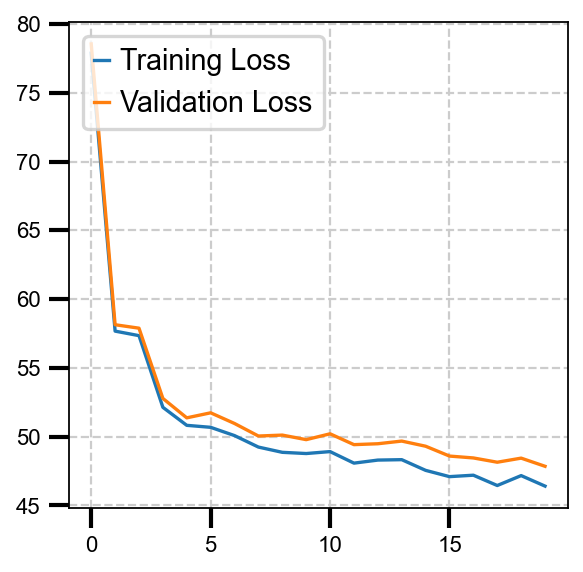

In [60]:
import matplotlib.pyplot as plt

#use to adjust the epochs

plt.plot(train_losses, label = "Training Loss")
plt.plot(val_losses, label = "Validation Loss")
plt.legend(loc = "upper left")
plt.grid(True, which="both", linestyle="--", linewidth = 1, alpha=1)
plt.tick_params(axis='both', which="major", labelsize = 10)
plt.show()

In [61]:
print(train_losses)
print(val_losses)

[77.87580210547566, 57.673032141911264, 57.34439979795854, 52.13510500095758, 50.82580331593436, 50.681153602734895, 50.07966254945357, 49.245574204407816, 48.863886142366766, 48.77612996724806, 48.91731918928059, 48.07837558651981, 48.30027919000956, 48.330266314934505, 47.5533879984394, 47.09663430742999, 47.2011641404654, 46.45170276763161, 47.17217728038559, 46.408110523560865]
[78.54720834025518, 58.13760374763622, 57.88720026910779, 52.782420238743526, 51.370398850433396, 51.736022045578224, 50.95946110299357, 50.04888878414476, 50.11658909589953, 49.786044292116394, 50.210108000447526, 49.42254100126379, 49.48733639982433, 49.68127002928329, 49.30757124738587, 48.59201684172468, 48.45520062590631, 48.14448193791182, 48.441622717391894, 47.84900043044826]


In [62]:
artifact = wandb.Artifact(f"best_model", type="model")
glob_str = os.path.join(save_dir, "best_model.pt")
artifact.add_file(glob_str)
run.log_artifact(artifact)

run.finish()
wandb.finish()
gc.collect()

avg_bio,▁█▄█
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
test/ARI_cluster/label,▁▇▄█
test/ASW_label,█▇▃▁
test/ASW_label/batch,▁▅▇█
test/NMI_cluster/label,▁█▅█
test/PCR_batch,▁▅▇█
test/avg_bio,▁█▄█
test/best_model_epoch,▁▃▆█
test/graph_conn,▁▆██
train/dab,██▇▄▄▁▅▁▂▄▄▃▄▆▄▂▂▁▂▅▄▅▅▃▄▃▄▂▅▄▆▄▂▂▅▂▃▃▄▃


32720